In [ ]:
# test creating reference datset with M3C function nico translated

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA


# function for creating a reference data set without clusters    
def create_ref_data(x, random_state = None):

    '''
    A function that returns a reference data set without any cluster structure.
    This function was translated from the "M3C" R package from Christopher John and David Watson (John et al., SciRep, 2020).
    The approach bases on Tibshirani et al. (2001) and preserves covariance structure of the data via PCA.
    
    Args:
        x: your data, can be a pandas dataframe or a matrix. rows should be the samples, columns the features.
        
    Returns:
        ref_data: reference data set for your data, same type (dataframe or matrix)
    '''
    
    # if dataframe is input, convert to matrix
    in_df = 0
    if isinstance(x, pd.core.frame.DataFrame):
        df_names = x.columns
        in_df = 1
        x = x.values
        
    # rows and columns
    r = x.shape[0]
    c = x.shape[1]
    
    # perform PCA
    pca = PCA()
    pca.fit(x)
    
    # rotated data
    x_t = pca.fit_transform(x.T)
    
    # function to get PCA covariance matrix and SDs
    def colSdColMeans(x):
        n = x.shape[0]
        colVar = np.mean(x * x, axis = 0) - (np.mean(x, axis = 0) ** 2)
        return np.sqrt(colVar * n / (n - 1))
    
    # get SDs from colSdColMeans function
    sds = colSdColMeans(x_t)
    
    # simulated data based on normal distributions: mean 0, sd from sds
    if random_state:
        np.random.seed(random_state)
    sim_data = np.random.normal(0, sds, (c, c))
    
    # create reference dataset
    ref_data = (np.matmul(sim_data, pca.components_) + pca.mean_).T
    
    # possibly back to dataframe
    if in_df:
        ref_data = pd.DataFrame(ref_data, columns = df_names)
    
    return ref_data

# alternative way of permuting the data
def permute_all_features(X):
    xperm = np.full(X.shape,np.nan)
    for c in range(X.shape[1]):
        feature = X[:,c]
        ss=np.linspace(0,X.shape[0]-1,X.shape[0])
        np.random.shuffle(ss)
        xperm[:,c]=feature[ss.astype(int)]
    return xperm

In [2]:
import csv
# data1: ixi with the artefact
# data2: the set with special samples
with open(('/Users/lee_jollans/Projects/clustering_pilot/IXI/IXI_Tc.csv'), "r") as f:
    data1 = np.array(list(csv.reader(f, delimiter=","))).astype(float)
with open(('/Users/lee_jollans/Projects/clustering_pilot/ALL/wspecsamp_Tc_ctrl.csv'), "r") as f:
    data2 = np.array(list(csv.reader(f, delimiter=","))).astype(float)

# get the labels for ixi and all
import pickle
with open(('/Users/lee_jollans/Projects/clustering_pilot/IXI/IXI_all_labelsmain_sigmoid.pkl'), "rb") as file:
    ixi_labelsmain2 = pickle.load(file)
labels1=ixi_labelsmain2[:,0,3,0]  
with open(('/Users/lee_jollans/Projects/clustering_pilot/ALL/wspecsamp_all_labelsmain_sigmoid.pkl'), "rb") as file:
    all_labelsmain2 = pickle.load(file)
labels2=all_labelsmain2[:,0,2,0]  

# get reference data
ref_data1=create_ref_data(data1, random_state = None)
ref_data2=create_ref_data(data2, random_state = None)

# get permuted data
perm_data1=permute_all_features(data1)
perm_data2=permute_all_features(data2)

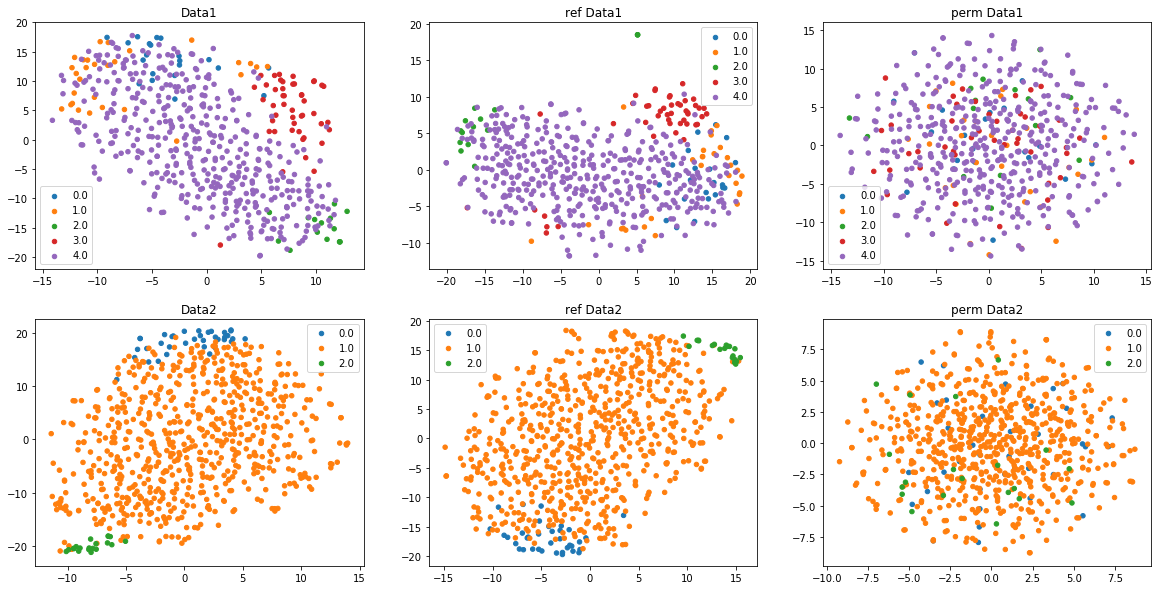

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/lee_jollans/Projects/clustering_pilot/may2020_evaluation')
from utils_for_ipynb_050520 import colorscatter

data1_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(data1)
data2_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(data2)
ref_data1_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(ref_data1)
ref_data2_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(ref_data2)
perm_data1_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(perm_data1)
perm_data2_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(perm_data2)

fig=plt.figure(figsize=[20,10])
ax=plt.subplot(2,3,1); colorscatter(data1_tsne, labels1, np.ones(544)*4, ax,1); plt.title('Data1')
ax=plt.subplot(2,3,4); colorscatter(data2_tsne, labels2, np.ones(740)*4, ax,1); plt.title('Data2')
ax=plt.subplot(2,3,2); colorscatter(ref_data1_tsne, labels1, np.ones(544)*4, ax,1); plt.title('ref Data1')
ax=plt.subplot(2,3,5); colorscatter(ref_data2_tsne, labels2, np.ones(740)*4, ax,1); plt.title('ref Data2')
ax=plt.subplot(2,3,3); colorscatter(perm_data1_tsne, labels1, np.ones(544)*4, ax,1); plt.title('perm Data1')
ax=plt.subplot(2,3,6); colorscatter(perm_data2_tsne, labels2, np.ones(740)*4, ax,1); plt.title('perm Data2')
plt.show()